### Setup

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import string
import os

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

2024-03-19 22:41:39.285916: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-19 22:41:42.435567: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-19 22:41:42.445284: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-19 22:41:57.855483: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Get the dataset

In [2]:
songdata = pd.read_csv("/home/login/Documents/songdata.csv", dtype = str)[:250]
songdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  250 non-null    object
 1   song    250 non-null    object
 2   link    250 non-null    object
 3   text    250 non-null    object
dtypes: object(4)
memory usage: 7.9+ KB


### 250 songs


### Preprocessing

In [3]:
def tokenize_corpus(corpus, num_words = -1):
    if num_words > -1:
        tokenizer = Tokenizer(num_words = num_words)
    else:
        tokenizer = Tokenizer()
    tokenizer.fit_on_texts(corpus)
    return tokenizer

def create_lyrics_corpus(dataset, field):
    dataset[field] = dataset[field].str.replace("[{}]".format(string.punctuation), "")
    dataset[field] = dataset[field].str.lower()
    lyrics = dataset[field].str.cat()
    corpus = lyrics.split("\n")
    
    for _ in range(len(corpus)):
        corpus[_] = corpus[_].rstrip()
        
    corpus = [_ for _ in corpus if _ != ""]
    return corpus

In [4]:
corpus = create_lyrics_corpus(songdata, "text")
tokenizer = tokenize_corpus(corpus)

total_words = len(tokenizer.word_index) + 1
print(total_words)

4151


### Create sequences

In [5]:
sequences = []
i = 0
for line in corpus:
    tok_line = tokenizer.texts_to_sequences([line])[0]
    for _ in range(1, len(tok_line)):
        line_sequences = tok_line[:_+1]
        sequences.append(line_sequences)
        
maxLength = max([len(_) for _ in sequences])
padded_sequences = pad_sequences(sequences, maxlen = maxLength, padding = "pre")
print(maxLength)
print(padded_sequences[0, :])

20
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
 112  65]


### Create labels

In [6]:
inputs, labels = padded_sequences[:, :-1], padded_sequences[:, -1]
one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes = total_words)
print(inputs[0])
print(labels[0])
print(one_hot_labels[0])
print(one_hot_labels[1])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
 112]
65
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


### Train a Better Text Generation Model

In [7]:
embedding_dim = 64
model = Sequential([
    Embedding(total_words, embedding_dim, input_length = maxLength - 1),
    Bidirectional(LSTM(20)),
    Dense(total_words, activation = "softmax")
])
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
             optimizer = tf.keras.optimizers.Adam(),
             metrics = ['accuracy'])

In [8]:
EPOCHS = 100
history = model.fit(inputs, one_hot_labels, epochs = EPOCHS, verbose = 1)

2024-03-19 22:42:18.186923: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 836675560 exceeds 10% of free system memory.


Epoch 1/100
1575/1575 [==============================] - 46s 20ms/step - loss: 6.3101 - accuracy: 0.0434
Epoch 2/100
1575/1575 [==============================] - 33s 21ms/step - loss: 5.9236 - accuracy: 0.0510
Epoch 3/100
1575/1575 [==============================] - 34s 22ms/step - loss: 5.6942 - accuracy: 0.0678
Epoch 4/100
1575/1575 [==============================] - 42s 27ms/step - loss: 5.4700 - accuracy: 0.0963
Epoch 5/100
1575/1575 [==============================] - 42s 27ms/step - loss: 5.2810 - accuracy: 0.1175
Epoch 6/100
1575/1575 [==============================] - 42s 27ms/step - loss: 5.0807 - accuracy: 0.1371
Epoch 7/100
1575/1575 [==============================] - 44s 28ms/step - loss: 4.8958 - accuracy: 0.1524
Epoch 8/100
1575/1575 [==============================] - 44s 28ms/step - loss: 4.7355 - accuracy: 0.1685
Epoch 9/100
1575/1575 [==============================] - 43s 27ms/step - loss: 4.5928 - accuracy: 0.1837
Epoch 10/100
1575/1575 [==============================]

1575/1575 [==============================] - 46s 29ms/step - loss: 2.1225 - accuracy: 0.5440
Epoch 79/100
1575/1575 [==============================] - 47s 30ms/step - loss: 2.1157 - accuracy: 0.5437
Epoch 80/100
1575/1575 [==============================] - 48s 30ms/step - loss: 2.1036 - accuracy: 0.5458
Epoch 81/100
1575/1575 [==============================] - 46s 29ms/step - loss: 2.0917 - accuracy: 0.5481
Epoch 82/100
1575/1575 [==============================] - 47s 30ms/step - loss: 2.0794 - accuracy: 0.5507
Epoch 83/100
1575/1575 [==============================] - 52s 33ms/step - loss: 2.0637 - accuracy: 0.5545
Epoch 84/100
1575/1575 [==============================] - 51s 32ms/step - loss: 2.0664 - accuracy: 0.5531
Epoch 85/100
1575/1575 [==============================] - 52s 33ms/step - loss: 2.0494 - accuracy: 0.5560
Epoch 86/100
1575/1575 [==============================] - 41s 26ms/step - loss: 2.0806 - accuracy: 0.5489
Epoch 87/100
1575/1575 [==============================] - 4

### Visualize the training

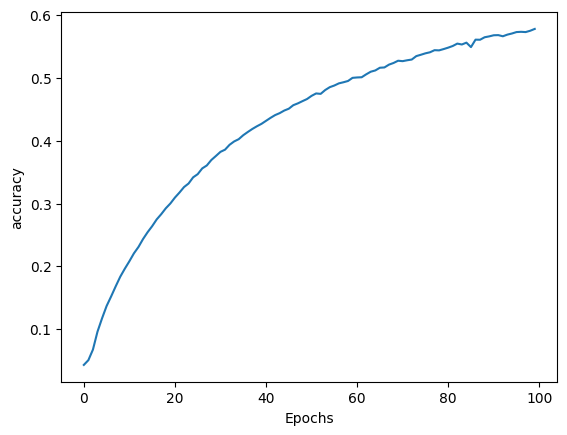

In [9]:
def plot_graphs(hist, string):
    plt.plot(hist.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()
    
plot_graphs(history, "accuracy")

### Save and Load model

In [12]:
if "saved_models" not in os.listdir():
    os.makedir("saved_models")
checkpoint_path = os.path.join("saved_models", "songs_optimized_text_generation.h5")
print(checkpoint_path)

saved_models/songs_optimized_text_generation.h5


In [14]:
model.save(checkpoint_path)

/home/login/.myenv/.myenv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
reloaded = tf.keras.models.load_model(checkpoint_path)
reloaded.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 19, 64)            265664    
                                                                 
 bidirectional (Bidirection  (None, 40)                13600     
 al)                                                             
                                                                 
 dense (Dense)               (None, 4151)              170191    
                                                                 
Total params: 449455 (1.71 MB)
Trainable params: 449455 (1.71 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 19, 64)            265664    
                                                                 
 bidirectional (Bidirection  (None, 40)                13600     
 al)                                                             
                                                                 
 dense (Dense)               (None, 4151)              170191    
                                                                 
Total params: 449455 (1.71 MB)
Trainable params: 449455 (1.71 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Generate better Lyrics

In [ ]:
seed_text = "I'm feeling chills"
next_words = 100

def gen_lyrics(seed_text, next_words):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences(token_list, maxlen = maxLength, padding = "pre")
        predict = model.predict(token_list)
        predicted = np.argmax(predict, axis = 1)
        output = ""
        
        for word,index in tokenizer.word_index.items():
            if index == predicted:
                output = word
                break
        seed_text += " " + output
    return seed_text

In [ ]:
print(gen_lyrics(seed_text, next_words))
print(gen_lyrics("I am feeling chills", 20))
print(gen_lyrics("Let's go home", 50))

### Varying the possible outputs

In [ ]:
seed_text = "I'm feeling chills"
next_words = 100

token_list = tokenizer.texts_to_sequences([seed_text])[0]
token_list = pad_sequences([token_list], maxlen = maxLength, padding = "pre")
predicted_probs = model.predict_proba(token_list, verbose = 0)[0]
predicted = np.random.choice([x for x in range(len(predicted_probs))],
                            p = predicted_probs)
print(predicted)

In [ ]:
seed_text = "I'm feeling chills"
num_words = 100

def generate_lyrics(seed_text, num_words):
    for _ in range(num_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen = maxLength, padding = 'pre')
        predicted_proba = model.predict_proba(token_list, verbose = 0)[0]
        predicted = np.random.choice([x for x in range(len(predicted_proba))],
                                    p = predicted_proba)
        output_word = ""
    
    for word, index in tokenizer.word_index.items():
        if predicted == index:
            output_word = word
            break
    seed_text += " " + output_word
    return seed_text

In [ ]:
print(generate_lyrics(seed_text, next_words))
print(generate_lyrics("I am feeling chills", 20))
print(generate_lyrics("Let's go home", 50))